# 化学空間と分子の類似性
化学空間(ケミカルスペース)とは, ケモインフォマティクスにおける重要な概念で, 与えられた構造原理と境界条件を遵守するすべての可能な分子によって広がる特性空間のことを指します(Wikipedia引用). より簡易的にいうと, Cの結合数は４とか, そういう分子として記述するためのルールを守りながら設計可能な分子を考えていき, それらの分子の特性 (物理化学的な性質など) を数値的に記述し, 配置したものを化学空間といいます.  
「空間」と聞くと縦・横・高さを持つ物理的な広がりを持った空間をイメージしがちですが, ここで用いられている空間の意味は, 数学で用いる空間に近いです. 
> **補足**  
> 数学でいう「空間」を厳密に説明することは難しいので (数学特有の記述方法が必要になってしまうので) 詳細な説明は省きますが, ざっくりと, ここでいう空間とは$n$次元の実数ベクトルとかが定められる設定だと思っていたいて大丈夫です. 数学では空間の設定が変わると扱える数(虚数なども含め)や距離の測り方などが変わりますが, ケモインフォでは基本的に実数空間で定義される$n$次元実数ベクトルしか扱いません. $n$次元実数ベクトルは高校数学で習ったようなベクトルのことを指します. 例えば,
> $$a = (1, 2)^T$$
> というようなベクトルがあった場合, このベクトルが記述されている空間は2次元実数空間といい, $a$ が2次元実数空間に属することを $a \in \mathbb{R}^2$ と書きます. また, 補足ですが, $N \times M$行列$A$が記述できる実数空間があった場合, $A \in \mathbb{R}^{N \times M}$ のように書きます.　深層学習では行列やそれをより抽象化したテンソルと呼ばれるものを扱って化合物を表現することがよくあります.

つまり, 化学空間とは化合物を何らかの尺度で$n$次元の実数空間に配置したものです. ここでよく用いられる尺度には, うまく化合物の特徴を表すような「距離」が定義されるように決められることが多いです. より具体的には, いろんな化合物に対して$n$次元の化学構造記述子を取得した場合, その化合物が表現される化学空間は$n$次元実数空間です. そして, その化学構造記述子の$n$次元ベクトルによっていろんな分子が数値的に配置されたものを化学空間と言います. 似た化学構造を持つ化合物は似た特性値を持つはずですので, 化学空間上の距離から, 化合物同士の類似性を測ることが可能です. 従って化学空間をうまく探索すれば, 所望の化合物を得ることができるはずです. しかし, 理論上, 潜在的な薬理活性分子の数は$10^{60}$オーダーであると推定されており, これは天文学的な数値になります. そのため, 人間が手作業で所望の化合物を自在に得ることは非常に困難です. この広大な化学空間からコンピュータを用いて効率的に物性を予測し, 所望の物性値を持つ化合物を探索・デザインしていくことが, ケモインフォマティクスの本質的な試みになります.


# 実装1. ケミカルスペースを可視化する

ライブラリのインポート

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from mordred import descriptors, Calculator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

rdkitのサンプルデータを使います.

In [2]:
df = pd.read_csv('water_solubility.csv').drop(175)
smiles = df['SMILES'].tolist()
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
logS = np.array(df['logS'])

各分子の特性を記述するために, mordred記述子を算出します.

In [3]:
def calc_mordred(mols, ignore_3D):
    global calc
    if ignore_3D:
        calc = Calculator(descriptors, ignore_3D=True)
    else:
        calc = Calculator(descriptors)
    # calculate descriptors
    df_mord = calc.pandas(mols)
    df_mord = df_mord.astype(str)
    masks = df_mord.apply(
        lambda d: d.str.contains('[a-zA-Z]', na=False))
    df_mord = df_mord[~masks]
    df_mord = df_mord.astype(float)
    return df_mord

In [5]:
df_mord = calc_mordred(mols, True)

100%|██████████| 1289/1289 [02:56<00:00,  7.31it/s]


可視化のための前処理をしていきます. とりあえず欠損がある列は全て削除します.

In [6]:
df_mold_prcessed = df_mord.dropna(axis=1)
df_mold_prcessed

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,2.449490,2.449490,0.0,0.0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,6.188264,24.179697,59.037114,6.559679,9.0,0.0,12.0,9.0,3.111111,1.000000
1,1.414214,1.414214,0.0,0.0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,4.174387,17.310771,46.053098,5.117011,4.0,0.0,6.0,4.0,2.250000,1.000000
2,2.449490,2.449490,1.0,0.0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,6.188264,24.179697,60.021129,7.502641,9.0,0.0,12.0,9.0,3.111111,1.000000
3,3.535534,3.535534,0.0,1.0,6.472136,2.000000,3.618034,6.472136,1.294427,2.525424,...,7.147559,41.004802,71.073499,5.076679,15.0,0.0,20.0,20.0,1.250000,1.250000
4,3.047207,3.305183,0.0,0.0,5.226252,1.847759,3.695518,5.226252,1.045250,2.408576,...,6.834109,27.254130,76.027277,8.447475,18.0,2.0,16.0,14.0,3.361111,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,13.808287,12.526035,0.0,0.0,22.612075,2.467255,4.934511,22.612075,1.256226,3.814497,...,9.969228,51.484360,357.844416,16.265655,537.0,32.0,94.0,113.0,7.888889,3.944444
1285,18.142136,12.647424,0.0,0.0,30.880509,2.521172,5.042344,30.880509,1.403660,4.078091,...,10.346024,57.149063,278.109550,7.725265,971.0,41.0,128.0,158.0,4.388889,4.666667
1286,18.687482,12.675910,0.0,0.0,31.425065,2.638574,5.277147,31.425065,1.428412,4.111337,...,10.634532,57.909470,276.093900,8.120409,815.0,49.0,138.0,178.0,4.111111,4.527778
1287,16.096016,14.757082,0.0,0.0,25.965456,2.507908,5.015816,25.965456,1.236450,3.967909,...,10.241566,55.541342,459.727499,20.896705,820.0,42.0,112.0,138.0,10.472222,4.555556


行の値が全て定数である列は削除します

In [7]:
# まず列ごとに分散を計算します.
vars = df_mold_prcessed.var(axis=0)

# 分散0でない列のbool値を取得する.
mask = (vars != 0).values

# 分散が0でない列だけ抜き出す
X = np.array(df_mold_prcessed)[:,mask]
print(X.shape)

(1289, 823)


823次元になりました. これを主成分分析(PCA)という次元圧縮手法を用いて２次元に圧縮し, ケミカルスペースを散布図で可視化してみます.

In [93]:
# PCAにかける前に変数を標準化する. 
scaler = StandardScaler()
X_std = scaler.fit_transform(X) # 縦方向(変数ごとに平均0標準偏差1にする) これにより変数間のスケールの違いを統一できます.

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
evr = pca.explained_variance_ratio_

print("explained_variance_ratio total:", (evr[0]+evr[1])*100)
print("explained_variance_ratio PC1:", evr[0]*100)
print("explained_variance_ratio PC2:", evr[1]*100)

explained_variance_ratio total: 49.80536010798473
explained_variance_ratio PC1: 40.62848634589082
explained_variance_ratio PC2: 9.176873762093905


(array([ 41., 131., 207., 192., 167., 112., 136.,  88.,  71.,  55.,  28.,
         24.,  13.,  16.,   5.,   0.,   1.,   1.,   0.,   1.]),
 array([-1.67573473, -1.34375233, -1.01176993, -0.67978752, -0.34780512,
        -0.01582271,  0.31615969,  0.64814209,  0.9801245 ,  1.3121069 ,
         1.6440893 ,  1.97607171,  2.30805411,  2.64003652,  2.97201892,
         3.30400132,  3.63598373,  3.96796613,  4.29994853,  4.63193094,
         4.96391334]),
 <BarContainer object of 20 artists>)

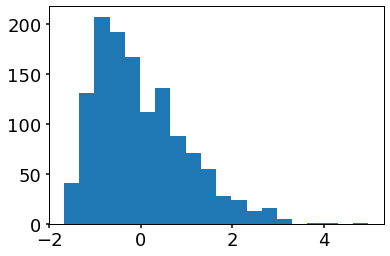

In [95]:
plt.hist(X_std[:,4], bins=20)

散布図を作成します.

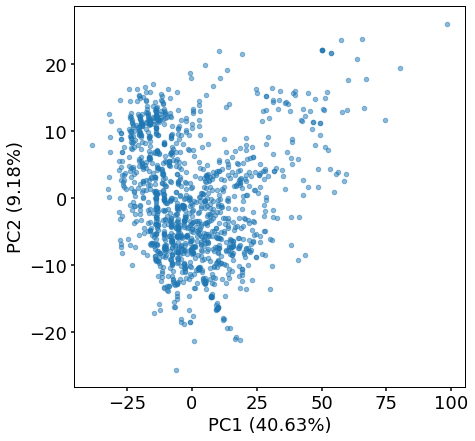

In [101]:
plt.figure(figsize=(7,7))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    s=20,
    alpha=0.5
     )
plt.xlabel(f'PC1 ({round(evr[0]*100, 2)}%)')
plt.ylabel(f'PC2 ({round(evr[1]*100, 2)}%)')
plt.show()

これだけだと分からないので, logSの値に応じて散布図に色をつけてみましょう

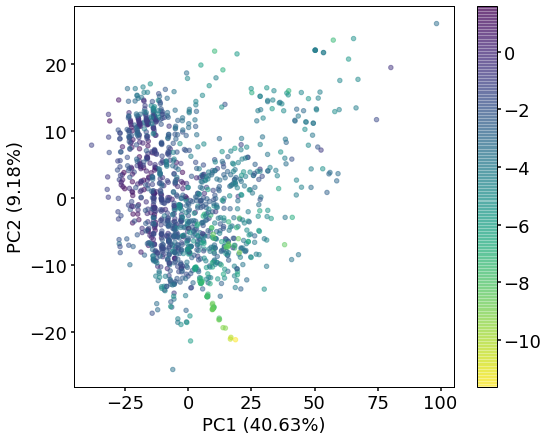

In [102]:
plt.figure(figsize=(8.5,7))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    s=20,
    alpha=0.5,
    c=logS,
    cmap=plt.cm.get_cmap('viridis_r')
     )
plt.xlabel(f'PC1 ({round(evr[0]*100, 2)}%)')
plt.ylabel(f'PC2 ({round(evr[1]*100, 2)}%)')
plt.colorbar()
plt.show()

こうやってみると, 左の方は溶解度が低く, 右下には溶解度が高いものが密集している傾向がわかります. このように, ケミカルスペースを可視化することで, 目的の物性が化学空間上にどのように分布しているかがわかります. 目的の物性を高めたい時に, このケミカルスペース上のどの位置にプロットが打てるような分子を設計すれば良いか, 指針を立てることができます. 似た構造を持つ分子は似た特性値を持つはずですから, ケミカルスペース上で近い位置にプロットされます. しかし, 例外なく似た分子が似た活性を有するわけでなく, １つの官能基の違いだけで飛躍的に活性が変わる **活性の崖(Activity Cliff)** があることに注意が必要です.

# 実装2. 化学空間の距離に基づいて分子の類似性を考える
標準化した化学空間上のノルム(距離をn次元に拡張した概念)から, 分子の類似性を考えます.

In [103]:
dist_matrix = np.zeros([X_std.shape[0], X_std.shape[0]])
for i in tqdm(range(X_std.shape[0])):
    for j in range(X_std.shape[0]):
        vector1 = X_std[i,:]
        vector2 = X_std[j,:]
        dist = np.linalg.norm(vector1 - vector2)
        dist_matrix[i, j] = dist

100%|██████████| 1289/1289 [00:23<00:00, 55.94it/s]


距離の度数分布を見てみる

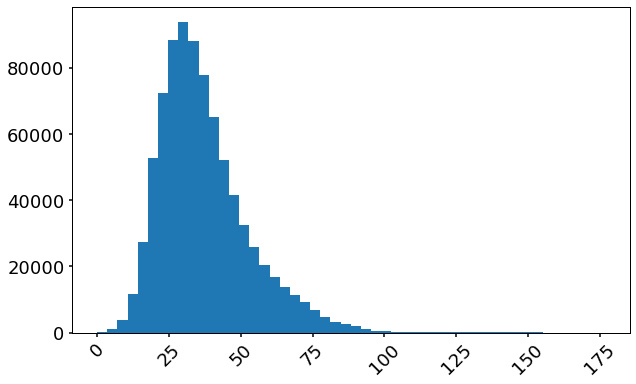

In [104]:
euclid_dist_unique = []
for i in range(dist_matrix.shape[0]):
    euclid_dist_unique.append(dist_matrix[i, i+1:]) # similarity行列の上半分(の三角形)だけ取得します. #i==jの成分は無視されます.
euclid_dist_uniqu = np.concatenate(euclid_dist_unique, axis=0) # 結果を全て結合して並べます

# 度数分布の描写
plt.figure(figsize=(10,6))
plt.hist(euclid_dist_uniqu, bins=50)
plt.xticks(rotation=45)
plt.show()

similarity matrixを可視化してみる

<ipython-input-105-baf04cd89deb>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_mesh, y_mesh, z_mesh, cmap=plt.cm.get_cmap('viridis'))


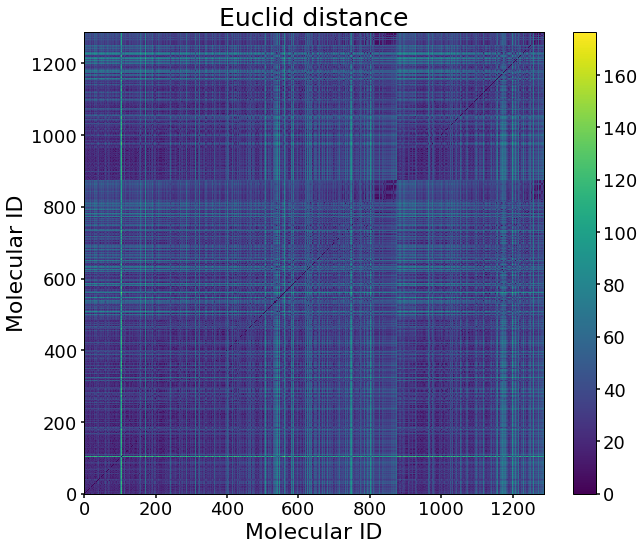

In [105]:
x = np.arange(len(mols))
y = np.arange(len(mols))
x_mesh, y_mesh = np.meshgrid(x, y)
z_mesh = dist_matrix

plt.rcParams['xtick.direction'] = 'out'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'out'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.5#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.5#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 18 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1# 軸の線幅edge linewidth。囲みの太さ

fig = plt.figure(figsize=(10.3, 8.5))
plt.title('Euclid distance', fontsize=25)
plt.xlabel('Molecular ID', fontsize=22)
plt.ylabel('Molecular ID', fontsize=22)
plt.pcolormesh(x_mesh, y_mesh, z_mesh, cmap=plt.cm.get_cmap('viridis'))
plt.colorbar()

plt.show()

最も距離の遠い化合物と最も距離が近い化合物の組み合わせを調べてみましょう

In [106]:
indexes = np.array([[i,j] for i in range(dist_matrix.shape[0]) for j in range(dist_matrix.shape[0])])
max_idx = np.argmax(dist_matrix)
max_ij = indexes[max_idx]
print(max_ij)

[ 549 1137]


どうやら549番目と1137番目の化合物の距離が最も遠いようです. 可視化してみましょう.

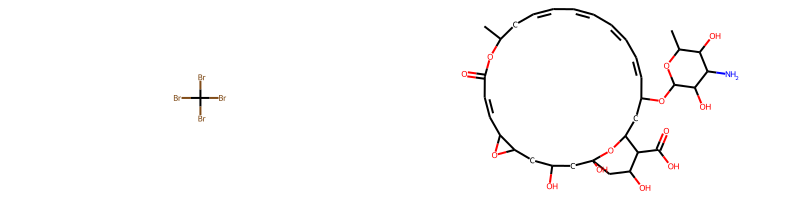

In [107]:
Draw.MolsToGridImage([mols[549], mols[1137]], molsPerRow=2, subImgSize=(400, 200))

確かに分子構造が全く異なります.

次に最も類似する分子を見てみましょう.  
```dist_matrix```の対角成分は同一化合物で必ず最小値になってしまうので, 対角成分を無視する処理もやってきます.

In [108]:
# まずi,jのインデックスの取り方を全て列挙する. dist_matrix.flatten()のインデックスの並びと同じになるように気をつける
indexes = np.array([[i,j] for i in range(dist_matrix.shape[0]) for j in range(dist_matrix.shape[0])])
# 次にnp.argsort()でdist_matrix.flatten()の値が小さい順にindexesを並び替える
sorted_indexes = indexes[np.argsort(dist_matrix.flatten())]
# sorted_indexesを順に探索していって, i!=jだった時のインデックスを取得したらそのまま探索を打ち切る
flag = False
for k in range(len(sorted_indexes)):
    if flag == True:
        break
    else:
        i, j = sorted_indexes[k]
        if i != j:
            min_ij = sorted_indexes[k]
            flag = True
print(min_ij)

[326 366]


326番目と366番目の化合物のユークリッド距離が似ているようです.  
可視化してみましょう.

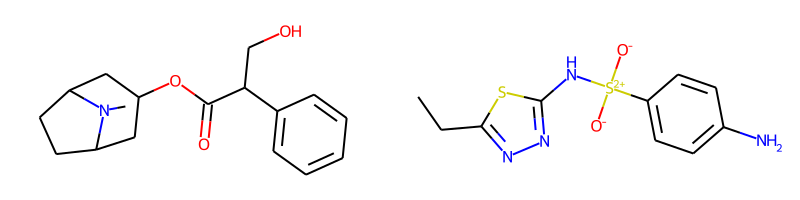

In [109]:
Draw.MolsToGridImage([mols[326], mols[336]], molsPerRow=2, subImgSize=(400, 200))

分子構造が似てますね. ユークリッド距離で類似性を考えても直感に反しない結果となりました.

# 実装3. Morganフィンガープリントで分子の類似性を評価する
フィンガープリントをもとにした分子の類似性評価の方法として, 「Tanimoto係数」と呼ばれるものがあります.　Tanimoto係数の考え方では, 分子間で共通する部分構造の割合をフィンガープリントに基づいて算出することで, 分子の類似性を数値化します. 具体的にはTanimoto係数は以下の式で計算されます.  
$$c_{Tanimoto}(A,B) = \frac{n (A \cap B)}{n (A \cup B)}$$
ここで, $n (A \cup B)$ は分子$A$と分子$B$の有する部分構造の総数, $n (A \cap B)$ は, 分子$A$と分子$B$で共通する部分構造の総数です. どんな部分構造を使うかはフィンガープリントの算出アルゴリズムによって異なりますので, 一口にTanimoto係数と言っても, どんなフィンガープリントに基づいて算出されたTanimoto係数であるかに注意する必要があります.  
では, 早速実装していきましょう.

まず, 必要なライブラリをインポートします. Mordredによるケミカルスペース可視化で使ったライブラリは既にインポートされているものとします.

In [110]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

MolオブジェクトをもとにMorganフィンガープリントを取得します. Tanimoto係数を算出する場合は,  Chapter3で行ったような, フィンガープリントをベクトルとして取得する```AllChem.GetMorganFingerprintAsBitVect```とは異なる```AllChem.GetMorganFingerprint```という関数を使っていきますので注意が必要です.

In [111]:
# radius = 2で Morgan fingerprintを取得する
fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

Tanimoto similarity matrixを作ります. データセット内の化合物の全ペアについてTanimoto係数を算出して化合物数×化合物数の行列として保存します.

In [112]:
Tanimoto_Similarities = np.zeros([len(mols), len(mols)]) # ここで化合物数×化合物数の要素が全て０の行列を作る.
# 二重ループで行方向, 列方向の各ペアについてTanimoto係数を算出する.
for i, fp1 in enumerate(fps):
    for j, fp2 in enumerate(fps):
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        Tanimoto_Similarities[i,j] = tanimoto_similarity

Tanimoto係数の分布を見てみましょう

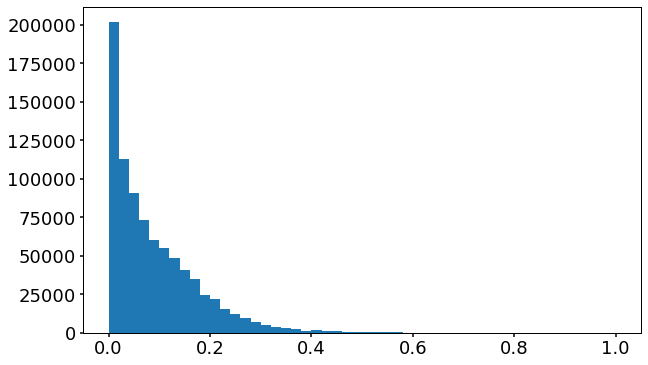

In [113]:
tanimoto_unique = []
for i in range(len(fps)):
    tanimoto_unique.append(Tanimoto_Similarities[i, i+1:]) # similarity行列の上半分(の三角形)だけ取得します. #i==jの成分は無視されます.
tanimoto_unique = np.concatenate(tanimoto_unique, axis=0) # 結果を全て結合して並べます

# 度数分布の描写
plt.figure(figsize=(10,6))
plt.hist(tanimoto_unique, bins=50)
plt.show()

Tanimoto係数の類似性行列をカラーマップにして可視化します.

<ipython-input-194-74dc248d07da>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_mesh, y_mesh, z_mesh)


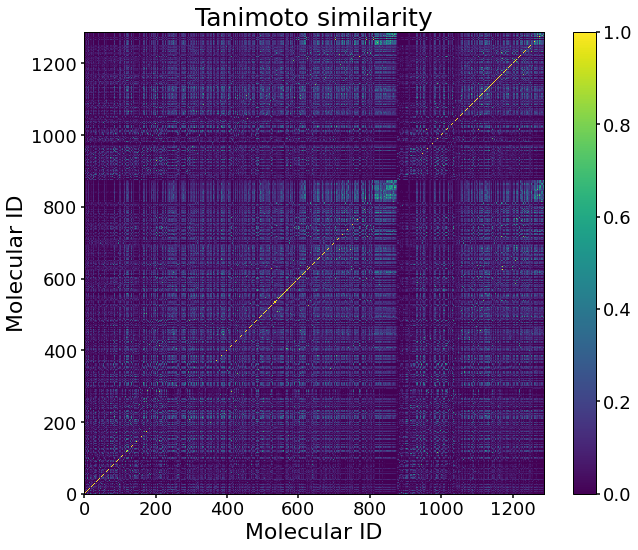

In [194]:
x = np.arange(len(mols))
y = np.arange(len(mols))
x_mesh, y_mesh = np.meshgrid(x, y)
z_mesh = Tanimoto_Similarities

plt.rcParams['xtick.direction'] = 'out'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'out'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.5#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.5#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 18 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1# 軸の線幅edge linewidth。囲みの太さ

fig = plt.figure(figsize=(10.3, 8.5))
plt.title('Tanimoto similarity', fontsize=25)
plt.xlabel('Molecular ID', fontsize=22)
plt.ylabel('Molecular ID', fontsize=22)
plt.pcolormesh(x_mesh, y_mesh, z_mesh)
plt.colorbar()

plt.show()

これで決定的な何かがわかるというわけではありませんが, カラーマップや度数分布を見ればデータセットが全体的にどの程度似通った分子の集団なのかを定量的に議論することができます. 2つ以上のデータセットを比較するなどに使っても良いかもしれません. 用途は無限に考えられますが, 深入りはしません. 興味のある方は論文などを読んでみてください.

最もTanimoto smilarityが高い(類似性の高い)化合物を見つけてみましょう. ```Tanimoto_Similarities```に基づいて探索しますが, やはりこれも対角成分は必ず1になってしまうので, 対角成分を無視する操作を加えていきます.

In [228]:
# まずi,jのインデックスの取り方を全て列挙する. Tanimoto_Similarities.flatten()のインデックスの並びと同じになるように気をつける
indexes = np.array([(i,j) for i in range(Tanimoto_Similarities.shape[0]) for j in range(Tanimoto_Similarities.shape[0])])

# 次にnp.argsort()でTanimoto_Similarities.flatten()の値が『大きい』順にindexesを並び替える
# np.argsort()は小さい順に並び替える操作しかできないので, -をかけたものの並びをソートする.
sorted_indexes = indexes[np.argsort(-1 * Tanimoto_Similarities.flatten())]

# sorted_indexesを順に探索していって, i!=jだった時のインデックスを取得したらそのまま探索を打ち切る
flag = False
for k in range(len(sorted_indexes)):
    if flag == True:
        break
    else:
        i, j = sorted_indexes[k]
        if i != j :
            max_ij = sorted_indexes[k]
            flag = True
            print(k)
print(max_ij)

119
[366 326]


366番目と326番目の化合物が最も類似性が高いと判定されました. 可視化してみます.

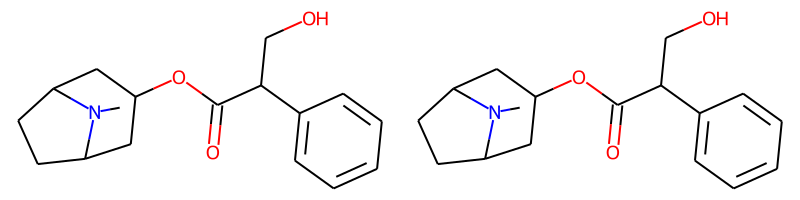

In [227]:
Draw.MolsToGridImage([mols[366], mols[326]], molsPerRow=2, subImgSize=(400, 200))

なんと全く同一化合物でした. データセットにインデックスが異なるけど同一な化合物があるようですね.  
しかし, tanimoto係数ではここまで一緒の化合物を同定できるとは. (同一なら当たり前か...)

試しに次に類似性の高い分子を見てみましょう

In [229]:
indexes = np.array([(i,j) for i in range(Tanimoto_Similarities.shape[0]) for j in range(Tanimoto_Similarities.shape[0])])
sorted_indexes = indexes[np.argsort(-1 * Tanimoto_Similarities.flatten())]

flag = False
for k in range(len(sorted_indexes)):
    if flag == True:
        break
    else:
        i, j = sorted_indexes[k]
        if i != j :
            if k == 119: # 119番目は飛ばす
                pass
            else:
                max_ij = sorted_indexes[k]
                flag = True
                print(k)
print(max_ij)

163
[589 493]


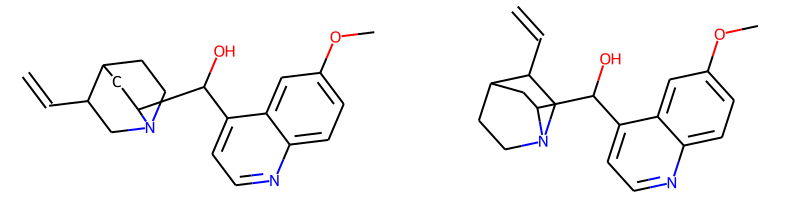

In [230]:
Draw.MolsToGridImage([mols[589], mols[493]], molsPerRow=2, subImgSize=(400, 200))

かなり良い線行ってます.

次に最も類似性の低い化合物を見つけましょう

In [ ]:
indexes = np.array([[i,j] for i in range(Tanimoto_Similarities.shape[0]) for j in range(Tanimoto_Similarities.shape[0])])
min_idx = np.argmin(Tanimoto_Similarities)
min_ij = indexes[min_idx]
print(min_ij)

[0 3]


0番目と３番目が類似性低いようです

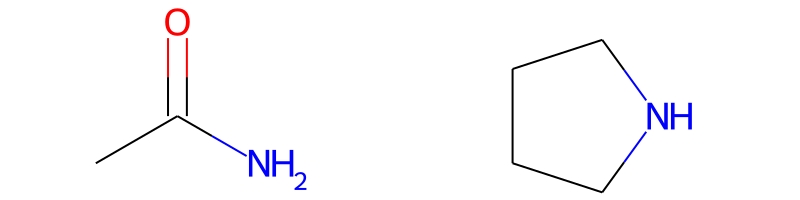

In [203]:
Draw.MolsToGridImage([mols[0], mols[3]], molsPerRow=2, subImgSize=(400, 200))

フィンガープリントベースでの判定なので、分子量などは反映されていません. 正直そんなに類似性が低いかと言われればそんな気はしませんが、以下で示したように, 確かに部分構造を共有していないので類似性が0になります.

In [206]:
print(Tanimoto_Similarities.flatten()[min_idx])

0.0
